In [20]:
import numpy as np
from reader import read_ptu
import matplotlib.pyplot as plt

In [16]:
data_path = 'data/august18/Amplitude-Phase-Flatness/500Hz-1mW-1s.ptu'
m, p  = read_ptu(data_path)
print(len(p)-10408)

344


## Ampltiude and Phase Flatness

In [22]:
from braun_lockin_original import *

files = ['data/august18/Amplitude-Phase-Flatness/500Hz-1mW-1s.ptu',
         'data/august18/Amplitude-Phase-Flatness/1000Hz-1mW-1s.ptu',
         'data/august18/Amplitude-Phase-Flatness/2000Hz-1mW-1s.ptu',
         'data/august18/Amplitude-Phase-Flatness/5000Hz-1mW-1s.ptu',
         'data/august18/Amplitude-Phase-Flatness/10000Hz-1mW-1s.ptu',
         'data/august18/Amplitude-Phase-Flatness/15000Hz-1mW-1s.ptu',
         'data/august18/Amplitude-Phase-Flatness/20000Hz-1mW-1s.ptu',
         'data/august18/Amplitude-Phase-Flatness/30000Hz-1mW-1s.ptu',
         'data/august18/Amplitude-Phase-Flatness/50000Hz-1mW-1s.ptu',
         'data/august18/Amplitude-Phase-Flatness/75000Hz-1mW-1s.ptu',
         'data/august18/Amplitude-Phase-Flatness/100000Hz-1mW-1s.ptu'
]
         
As =[]
Phis = []

M = 50
trim_ends = 1

for file in files:
    
    marker_ps, photon_ps = read_ptu(data_path)
    if marker_ps.size < 3:
        raise SystemExit("Not enough marker edges in CH0 to estimate f_ref robustly.")
    if photon_ps.size == 0:
        raise SystemExit("No photons found on CH1.")

    T, t0 = fit_period_from_markers(marker_ps)
    f_ref = 1.0 / T

    edges_s = make_sampling_grid(marker_ps, T, M, trim_ends)
    centers_s = 0.5 * (edges_s[:-1] + edges_s[1:])
    f_sample = M * f_ref

    N_raw, t_s = bin_photons(photon_ps, edges_s)

    Rx, Ry = build_references(t_s, T, t0)

    A, phi, I_dc = project_small_signal(N_raw, Rx, Ry)

    As.append(A)
    Phis.append(phi)

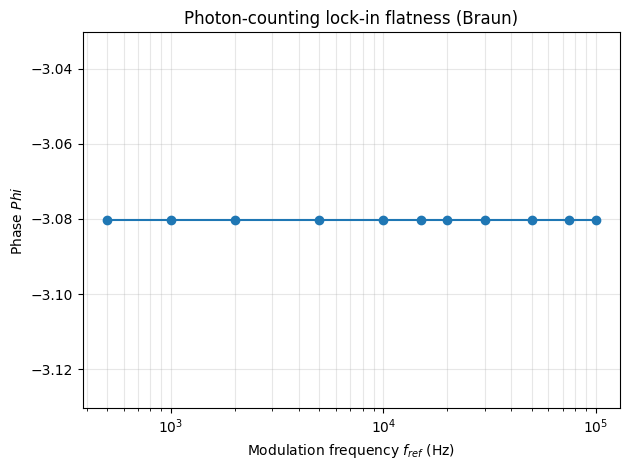

In [27]:
freqs = [500, 1000, 2000, 5000, 1e4, 1.5e4, 2e4, 3e4, 5e4, 7.5e4, 1e5]

fig, ax = plt.subplots()
ax.plot(freqs, Phis, marker="o")  
if max(freqs) / min(freqs) > 5.0:
    ax.set_xscale("log")

ax.set_xlabel("Modulation frequency $f_{ref}$ (Hz)")
ax.set_ylabel("Phase $Phi$")
ax.set_title("Photon-counting lock-in flatness (Braun)")

    
ymin = min(Phis); ymax = max(Phis)
pad = 0.05 * (ymax - ymin if ymax > ymin else 1.0)
ax.set_ylim(ymin - pad, ymax + pad)

ax.grid(True, which="both", alpha=0.3)
plt.tight_layout()
plt.show()

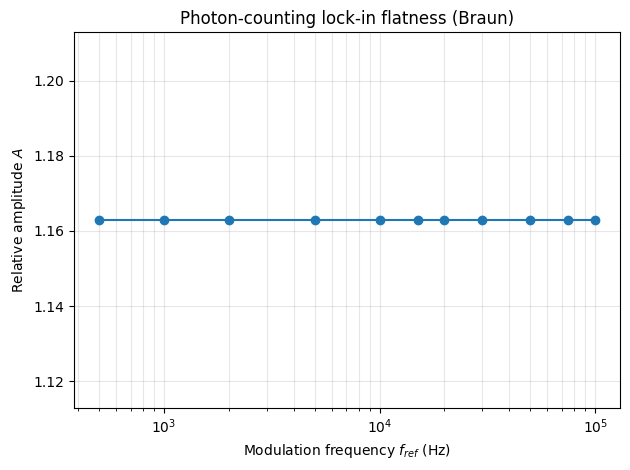

In [ ]:
fig, ax = plt.subplots()
ax.plot(freqs, As, marker="o")  
if max(freqs) / min(freqs) > 5.0:
    ax.set_xscale("log")

ax.set_xlabel("Modulation frequency $f_{ref}$ (Hz)")
ax.set_ylabel("Relative amplitude $A$")
ax.set_title("Photon-counting lock-in flatness (Braun)")

    
ymin = min(As); ymax = max(As)
pad = 0.05 * (ymax - ymin if ymax > ymin else 1.0)
ax.set_ylim(ymin - pad, ymax + pad)

ax.grid(True, which="both", alpha=0.3)
plt.tight_layout()
plt.show()


## Counting SNRs, Amplitudes and Phis Spreads

In [ ]:
path = 'data/august18/SNR-Lockin/50kHz-1mW-300s.ptu'
m, p  = read_ptu(path)

np.int64(299999982747540)

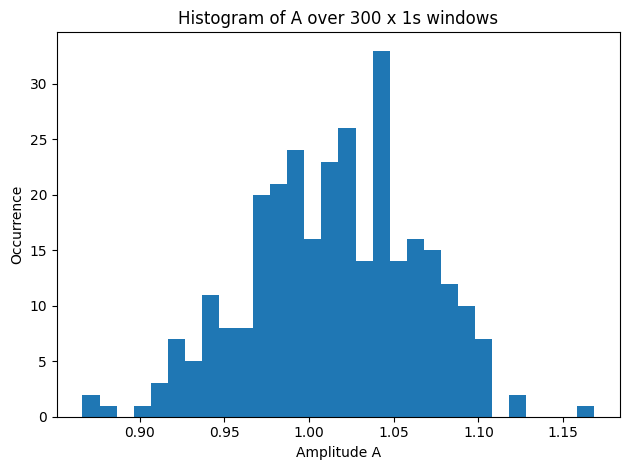

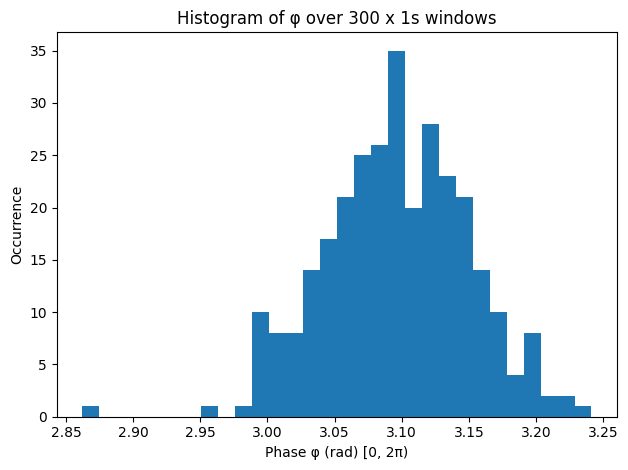

                 metric      mean       std        SNR
0           Amplitude A  1.015282  0.049554  20.488431
1    Phase φ (circular)  3.096124  0.053567        NaN
2  Phase φ (linearized)  3.096124  0.053660  57.698498


In [36]:
import os
import math
from typing import Tuple, List
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

try:
    from reader import read_ptu
except Exception as e:
    print("Could not import reader.read_ptu. Make sure reader.py is in the working directory.")
    raise

def fit_period_from_markers_ps(marker_ps: np.ndarray) -> Tuple[float, float]:
    """
    Linear regression: t ≈ a*z + b over marker edges.
    Returns (T_sec, t0_sec). marker_ps in picoseconds.
    """
    if marker_ps.size < 2:
        raise ValueError("Not enough marker edges to estimate period.")
    t = marker_ps.astype(np.float64) * 1e-12  # ps -> s
    z = np.arange(t.size, dtype=np.float64)
    A = np.vstack([z, np.ones_like(z)]).T
    a, b = np.linalg.lstsq(A, t, rcond=None)[0]  # a ~ T, b ~ t0
    if a <= 0:
        raise ValueError("Non-positive period estimated from markers.")
    return float(a), float(b)

def make_edges_for_window(t_start_s: float, t_stop_s: float, T: float, M: int) -> np.ndarray:
    """
    Build uniform sampling edges in seconds over [t_start_s, t_stop_s] with dt = T/M.
    """
    if t_stop_s <= t_start_s:
        return np.array([t_start_s, t_stop_s], dtype=np.float64)
    dt = T / float(M)
    n_edges = int(math.floor((t_stop_s - t_start_s) / dt)) + 1
    edges = t_start_s + np.arange(n_edges, dtype=np.float64) * dt
    # Ensure last edge is exactly the window end (right-open convention for histogram)
    if edges[-1] < t_stop_s:
        edges = np.append(edges, t_stop_s)
    else:
        edges[-1] = t_stop_s
    return edges

def bin_photons_to_edges(photon_ps: np.ndarray, edges_s: np.ndarray) -> Tuple[np.ndarray, np.ndarray]:
    """
    Histogram photons to edges (seconds). Returns counts per bin and bin centers (seconds).
    """
    if photon_ps.size == 0:
        counts = np.zeros(edges_s.size - 1, dtype=np.int64)
        centers = 0.5 * (edges_s[:-1] + edges_s[1:])
        return counts, centers
    t = photon_ps.astype(np.float64) * 1e-12
    counts, _ = np.histogram(t, bins=edges_s)
    centers = 0.5 * (edges_s[:-1] + edges_s[1:])
    return counts.astype(np.int64), centers

def build_refs_on_centers(centers_s: np.ndarray, T: float, t0: float) -> Tuple[np.ndarray, np.ndarray]:
    """
    Sin and cos references at the bin centers.
    """
    phase = 2.0 * np.pi * (centers_s - t0) / T
    Rx = np.sin(phase)
    Ry = np.cos(phase)
    return Rx, Ry

def project_to_A_phi(N_raw: np.ndarray, Rx: np.ndarray, Ry: np.ndarray) -> Tuple[float, float, float]:
    """
    Mean-subtract N_raw and project onto Rx,Ry (least squares). Returns (A, phi, I_dc).
    """
    Nf = N_raw.astype(np.float64)
    I_dc = float(Nf.mean())
    N = Nf - I_dc
    denom_x = float(np.dot(Rx, Rx))
    denom_y = float(np.dot(Ry, Ry))
    if denom_x == 0 or denom_y == 0:
        raise ValueError("Zero reference power in Rx/Ry.")
    Xhat = float(np.dot(N, Rx) / denom_x)
    Yhat = float(np.dot(N, Ry) / denom_y)
    A = float(np.hypot(Xhat, Yhat) / (I_dc if I_dc > 0 else np.nan))
    phi = float(np.arctan2(Yhat, Xhat))  # (-pi, pi]
    return A, phi, I_dc

def braun_A_phi_on_window(marker_ps: np.ndarray,
                          photon_ps: np.ndarray,
                          t0_s: float,
                          t1_s: float,
                          M: int = 50) -> Tuple[float, float, float, int]:
    """
    Compute Braun A and phi on a single time window [t0_s, t1_s).
    Returns (A, phi, I_dc, photons_used).
    """
    if t1_s <= t0_s:
        return float("nan"), float("nan"), float("nan"), 0

    # Select markers / photons in this window
    msel = (marker_ps >= int(t0_s * 1e12)) & (marker_ps < int(t1_s * 1e12))
    psel = (photon_ps >= int(t0_s * 1e12)) & (photon_ps < int(t1_s * 1e12))
    mk = marker_ps[msel]
    ph = photon_ps[psel]

    if mk.size < 2 or ph.size == 0:
        return float("nan"), float("nan"), float("nan"), int(ph.size)

    # Estimate T and t0 from markers in this window
    T, t0 = fit_period_from_markers_ps(mk)

    # Build sampling edges and bin photons
    edges_s = make_edges_for_window(t0_s, t1_s, T, M)
    N_raw, centers_s = bin_photons_to_edges(ph, edges_s)
    if N_raw.size < 4:
        return float("nan"), float("nan"), float("nan"), int(ph.size)

    # References and projection
    Rx, Ry = build_refs_on_centers(centers_s, T, t0)
    A, phi, I_dc = project_to_A_phi(N_raw, Rx, Ry)
    return A, phi, I_dc, int(ph.size)

path = 'data/august18/SNR-Lockin/50kHz-1mW-300s.ptu'

if not os.path.exists(path):
    print(f"File not found: {path}\n"
          f"Please adjust `path` to your PTU file. The rest of the notebook code is ready to run.")
else:
    # Read timestamps (ps)
    marker_ps, photon_ps = read_ptu(path)
    if marker_ps.size == 0 or photon_ps.size == 0:
        raise RuntimeError("No markers or photons found in the PTU file.")

    # Determine run bounds in seconds from the timestamps (robust to first/last being markers or photons)
    t_start_s = min(marker_ps.min(), photon_ps.min()) * 1e-12
    t_stop_s  = max(marker_ps.max(), photon_ps.max()) * 1e-12

    # Snap to integer seconds (0..300) as requested
    # We'll start from floor(t_start_s) and take 300 consecutive 1s windows
    start_floor = math.floor(t_start_s)
    windows = [(start_floor + k, start_floor + k + 1) for k in range(300)]

    # Compute Braun A, phi per second
    M = 50  # oversampling bins per period (Braun used ~50)
    A_list: List[float] = []
    phi_list: List[float] = []
    photons_used: List[int] = []
    Idc_list: List[float] = []

    for (s0, s1) in windows:
        A, phi, Idc, nph = braun_A_phi_on_window(marker_ps, photon_ps, s0, s1, M=M)
        A_list.append(A)
        phi_list.append(phi)
        photons_used.append(nph)
        Idc_list.append(Idc)

    A_arr = np.asarray(A_list, dtype=float)
    phi_arr = np.asarray(phi_list, dtype=float)

    # Drop NaNs (windows with insufficient edges/photons)
    ok = np.isfinite(A_arr) & np.isfinite(phi_arr)
    A_arr = A_arr[ok]
    phi_arr = phi_arr[ok]

    # Wrap phases to [0, 2π)
    phi_02pi = np.mod(phi_arr, 2.0 * np.pi)

    # ----- Histograms -----
    # Amplitude histogram
    plt.figure()
    plt.hist(A_arr, bins=30)  # default colors, one chart
    plt.xlabel("Amplitude A")
    plt.ylabel("Occurrence")
    plt.title("Histogram of A over 300 x 1s windows")
    plt.tight_layout()
    plt.show()

    # Phase histogram (0..2π)
    plt.figure()
    plt.hist(phi_02pi, bins=30)  # default colors, one chart
    plt.xlabel("Phase φ (rad) [0, 2π)")
    plt.ylabel("Occurrence")
    plt.title("Histogram of φ over 300 x 1s windows")
    plt.tight_layout()
    plt.show()

    
    A_mean = float(np.nanmean(A_arr))
    A_std  = float(np.nanstd(A_arr, ddof=1)) if A_arr.size > 1 else float("nan")
    A_SNR  = float(A_mean / A_std) if (A_std and np.isfinite(A_std) and A_std > 0) else float("nan")

    
    sin_m = np.mean(np.sin(phi_arr))
    cos_m = np.mean(np.cos(phi_arr))
    phi_mean = float(np.arctan2(sin_m, cos_m))  # in (-π, π]
    R = float(np.hypot(sin_m, cos_m))
    
    phi_std_circ = float(np.sqrt(max(0.0, -2.0 * np.log(max(R, 1e-12)))))
    
    phi_centered = (phi_arr - phi_mean + np.pi) % (2*np.pi) - np.pi
    phi_std_lin = float(np.std(phi_centered, ddof=1)) if phi_centered.size > 1 else float("nan")
    
    phi_SNR_lin = float(abs(phi_mean) / phi_std_lin) if (phi_std_lin and np.isfinite(phi_std_lin) and phi_std_lin > 0) else float("nan")

    # Summarize
    summary = pd.DataFrame({
        "metric": ["Amplitude A", "Phase φ (circular)", "Phase φ (linearized)"],
        "mean":   [A_mean,        phi_mean,             phi_mean],
        "std":    [A_std,         phi_std_circ,         phi_std_lin],
        "SNR":    [A_SNR,         np.nan,               phi_SNR_lin],
    })

    print(summary)


In [45]:

def _bracket_phase_fractions(photon_ps: np.ndarray, marker_ps: np.ndarray):
    """
    Vectorized bracketing:
      Find previous and next marker for each photon to get a *local full period*.
      Return (valid_mask, phi, t_ph) where phi ∈ [0,1) is the phase fraction.
    """
    if photon_ps.size == 0 or marker_ps.size < 2:
        return np.zeros(0, dtype=bool), np.zeros(0, dtype=float), photon_ps

    # indices of the first marker strictly greater than photon
    right = np.searchsorted(marker_ps, photon_ps, side="right")
    valid = (right > 0) & (right < marker_ps.size)
    if not np.any(valid):
        return valid, np.zeros(0, dtype=float), photon_ps

    r_prev = marker_ps[right[valid] - 1].astype(np.float64)
    r_next = marker_ps[right[valid]].astype(np.float64)
    t_ph   = photon_ps[valid].astype(np.float64)

    T = r_next - r_prev
    good = T > 0
    if not np.any(good):
        return np.zeros_like(valid, dtype=bool), np.zeros(0, dtype=float), photon_ps

    phi = ((t_ph[good] - r_prev[good]) / T[good]) % 1.0
    valid_mask = np.zeros_like(valid, dtype=bool)
    valid_idx = np.nonzero(valid)[0][good]
    valid_mask[valid_idx] = True
    return valid_mask, phi, photon_ps[valid_mask]


def _square_weights(phi: np.ndarray, duty: float, shift: float):
    """Bipolar ±1 square-wave weights; +1 in ON window, -1 in OFF."""
    x = (phi + shift) % 1.0
    on = x < duty
    w = np.empty_like(phi, dtype=float)
    w[on] = 1.0
    w[~on] = -1.0
    return w


def liu_S_per_second(path: str, N_seconds: int = 300, duty: float = 0.5):
    """
    Compute Liu's S = |I| + |Q| per 1-second bin for a file, efficiently.
    - Reads PTU once.
    - Phases from *bracketing full periods* (rising→rising), vectorized.
    - Accumulates I and Q per-second with np.bincount.
    Returns (edges_s, S_bins, I_bins, Q_bins, N_ph_bins).
    """
    markers_ps, photons_ps = read_ptu(path)
    if markers_ps.size < 2:
        raise RuntimeError("Not enough marker edges to determine periods.")
    if photons_ps.size == 0:
        raise RuntimeError("No photons found.")

    # Compute phases for all photons in one pass
    valid_mask, phi, t_ph_valid = _bracket_phase_fractions(photons_ps, markers_ps)
    if phi.size == 0:
        raise RuntimeError("No photons with valid bracketing periods.")

    # Compute weights for I (0°) and Q (+90°)
    wI = _square_weights(phi, duty=duty, shift=0.0)
    wQ = _square_weights(phi, duty=duty, shift=0.25)

    # Build 1-second bin indices relative to the run start (floor to whole second)
    t0_s = math.floor(min(markers_ps.min(), photons_ps.min()) * 1e-12)
    # Which 1-second bin does each valid photon fall into?
    idx = ((t_ph_valid * 1e-12) - t0_s).astype(np.int64)  # integer seconds since t0_s
    # Keep only [0, N_seconds) to match the user's request
    in_range = (idx >= 0) & (idx < N_seconds)
    idx = idx[in_range]
    wI = wI[in_range]
    wQ = wQ[in_range]

    # Aggregate with bincount
    I_bins = np.bincount(idx, weights=wI, minlength=N_seconds)
    Q_bins = np.bincount(idx, weights=wQ, minlength=N_seconds)
    N_bins = np.bincount(idx, minlength=N_seconds)  # photons per second

    S_bins = np.abs(I_bins) + np.abs(Q_bins)

    edges_s = t0_s + np.arange(N_seconds + 1, dtype=float)
    return edges_s, S_bins, I_bins, Q_bins, N_bins

def snr_mean_over_std(values: np.ndarray):
    vals = np.asarray(values, dtype=float)
    if vals.size < 2:
        return float("nan"), float("nan"), float("nan")
    m = float(np.mean(vals))
    s = float(np.std(vals, ddof=1))
    return (m / s if s > 0 else float("inf")), m, s

def traditional_counting_snr(signal_path: str, background_path: str, N_seconds: int = 300):
    """
    SNR for plain counting with background subtraction:
      - Bin signal photons into 1 s bins (no markers needed)
      - Estimate background rate (cts/s) from its timestamps
      - true_signal[k] = signal_counts[k] - bg_rate
      - SNR = mean(true_signal) / std(true_signal)
    """
    _, p_sig = read_ptu(signal_path)
    if p_sig.size == 0:
        raise RuntimeError("No photons in signal file.")
    t0_s_sig = math.floor(p_sig.min() * 1e-12)             
    idx_sig = ((p_sig * 1e-12) - t0_s_sig).astype(np.int64) 
    in_range_sig = (idx_sig >= 0) & (idx_sig < N_seconds)
    sig_bins = np.bincount(idx_sig[in_range_sig], minlength=N_seconds)

    _, p_bg = read_ptu(background_path)
    if p_bg.size == 0:
        raise RuntimeError("No photons in background file.")
    t_bg = (p_bg.max() - p_bg.min()) * 1e-12
    if t_bg <= 0:
        t_bg = 60.0  
    bg_rate = len(p_bg) / t_bg

    true_signal = sig_bins.astype(float) - bg_rate
    snr, m, s = snr_mean_over_std(true_signal)
    return snr, m, s, true_signal, sig_bins, bg_rate

# Liu lock-in SNR over 300 bins
liu_path = 'data/august18/SNR-Lockin/50kHz-1mW-100s-MaxND.ptu'
if os.path.exists(liu_path):
    edges_s, S_bins, I_bins, Q_bins, N_bins = liu_S_per_second(liu_path, N_seconds=100, duty=0.5)
    snr_liu, mean_S, std_S = snr_mean_over_std(S_bins)
    print(f"[Liu] SNR = mean/std = {snr_liu:.4f}  (mean={mean_S:.4f}, std={std_S:.4f})")
else:
    print(f"[Liu] File not found: {liu_path} — adjust the path and re-run.")

# counting with background subtraction
signal_path = 'data/august18/SNR-Lockin/50kHz-1mW-100s-MaxND.ptu'
background_path = 'data/august18/Background-Rejection/50kHz-0mW-60s.ptu'
if os.path.exists(signal_path) and os.path.exists(background_path):
    snr_trad, m_trad, s_trad, true_signal, sig_bins, bg_rate = traditional_counting_snr(
        signal_path, background_path, N_seconds=100
    )
    print(f"[Trad] SNR = {snr_trad:.4f}  (mean={m_trad:.4f}, std={s_trad:.4f}), background_rate={bg_rate:.3f} cts/s")
else:
    print("[Trad] Adjust signal_path/background_path to valid files and re-run.")


[Liu] SNR = mean/std = 5.1785  (mean=273.6400, std=52.8420)
[Trad] SNR = 4.5366  (mean=253.3203, std=55.8391), background_rate=377.500 cts/s


# Braun A, Phi shot noise limited

In [46]:
files = [
    'data/august18/Shot-Noise-Limits/50kHz-1mW-40s.ptu',
    'data/august18/Shot-Noise-Limits/50kHz-2mW-40s.ptu',
    'data/august18/Shot-Noise-Limits/50kHz-3mW-40s.ptu',
    'data/august18/Shot-Noise-Limits/50kHz-10mW-40s.ptu',
    'data/august18/Shot-Noise-Limits/50kHz-20mW-40s.ptu',
    'data/august18/Shot-Noise-Limits/50kHz-30mW-40s.ptu',
    'data/august18/Shot-Noise-Limits/50kHz-40mW-40s.ptu',
    'data/august18/Shot-Noise-Limits/50kHz-50mW-40s.ptu',
    'data/august18/Shot-Noise-Limits/50kHz-60mW-40s.ptu',
    'data/august18/Shot-Noise-Limits/50kHz-80mW-40s.ptu',
    'data/august18/Shot-Noise-Limits/50kHz-100mW-40s.ptu'
]

a_std = []
phi_std = []
I_std = []
I_mean = []


for file in files:
    marker_ps, photon_ps = read_ptu(file)

    t_start_s = min(marker_ps.min(), photon_ps.min()) * 1e-12
    t_stop_s  = max(marker_ps.max(), photon_ps.max()) * 1e-12

    start_floor = math.floor(t_start_s)
    windows = [(start_floor + k, start_floor + k + 1) for k in range(40)]

    M = 50  
    A_list: List[float] = []
    phi_list: List[float] = []
    photons_used: List[int] = []

    for (s0, s1) in windows:
        A, phi, Idc, nph = braun_A_phi_on_window(marker_ps, photon_ps, s0, s1, M=M)
        A_list.append(A)
        phi_list.append(phi)
        photons_used.append(nph)
        
    Astd = np.std(A_list)
    pstd = np.std(phi_list)
    mean_I = np.mean(photons_used)
    std_I = np.std(photons_used)
    
    a_std.append(Astd)
    phi_std.append(pstd)
    I_std.append(std_I)
    I_mean.append(mean_I)

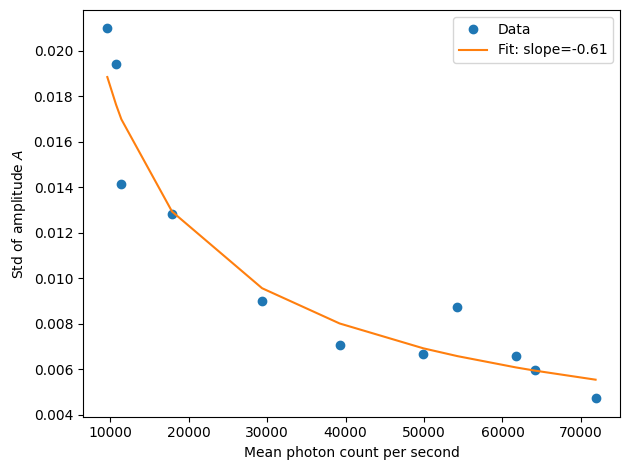

Slope: -0.609
R² score: 0.9233


In [50]:
from scipy.stats import linregress

x = np.array(I_mean)
y = np.array(a_std)

plt.figure()
plt.plot(x, y, 'o', label='Data')  # linear y axis

logx = np.log10(x)
logy = np.log10(y)
slope, intercept, r_value, p_value, std_err = linregress(logx, logy)
plt.plot(x, 10**(intercept) * x**slope, '-', label=f'Fit: slope={slope:.2f}')

plt.xlabel('Mean photon count per second')
plt.ylabel('Std of amplitude $A$')
plt.legend()
plt.tight_layout()
plt.show()

print(f"Slope: {slope:.3f}")
print(f"R² score: {r_value**2:.4f}")